In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error

# Đọc dữ liệu vào từ file csv
data = pd.read_csv('ACB Historical Data.csv', index_col='Date', parse_dates=True)

# Chọn các cột 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %' cho model VAR
cols = ['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']
data = data[cols]

# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)
    
# Áp dụng hàm chuyển đổi cho cột "Vol."
data["Vol."] = data["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
data["Change %"] = data["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
data['Price'] = data['Price'].apply(convert_str_to_number)
data['Open'] = data['Open'].apply(convert_str_to_number)
data['High'] = data['High'].apply(convert_str_to_number)
data['Low'] = data['Low'].apply(convert_str_to_number)

data

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2017-12-01,10537.7,10477.8,10567.6,10417.9,7360000,0.0086
2017-12-04,10926.9,10537.7,10956.8,10537.7,9450000,0.0369
2017-12-05,10477.8,10956.8,10956.8,10477.8,8189999,-0.0411
2017-12-06,10447.9,10447.9,10627.5,10328.1,9810000,-0.0029
2017-12-07,10837.1,10447.9,10837.1,10447.9,8300000,0.0373
...,...,...,...,...,...,...
2023-04-24,24200.0,24300.0,24450.0,24100.0,2270000,-0.0021
2023-04-25,24150.0,24300.0,24450.0,24100.0,6170000,-0.0021
2023-04-26,24150.0,24150.0,24200.0,23950.0,3860000,0.0000


In [2]:
# Chia dữ liệu thành các tập train, test và validate theo tỷ lệ 7/2/1
train_data = data.iloc[:int(0.7*len(data)), :]
test_data = data.iloc[int(0.7*len(data)):int(0.9*len(data)), :]
val_data = data.iloc[int(0.9*len(data)):, :]

In [3]:
# Chuyển đổi dữ liệu thành dạng ma trận
train_X = train_data[['Open', 'High', 'Low', 'Vol.', 'Change %']].values
train_y = train_data['Price'].values

val_X = val_data[['Open', 'High', 'Low', 'Vol.', 'Change %']].values
val_y = val_data['Price'].values

test_X = test_data[['Open', 'High', 'Low', 'Vol.', 'Change %']].values
test_y = test_data['Price'].values

# Xác định số lượng lags tối ưu
best_p = 0
best_rmse = float('inf')

for p in range(1, 6):
    model = VAR(train_X)
    results = model.fit(p)
    
    val_pred = results.forecast(train_X[-p:], len(val_X))
    rmse = np.sqrt(mean_squared_error(val_y, val_pred[:, 0]))
    print(f'p={p}, RMSE={rmse}')
    if rmse < best_rmse:
        best_p = p
        best_rmse = rmse

p=1, RMSE=2665.6899726573442
p=2, RMSE=2680.7486998098543
p=3, RMSE=2950.9880959655866
p=4, RMSE=2717.1543175759934
p=5, RMSE=2889.7953364479504


In [4]:
# Huấn luyện model VAR trên toàn bộ tập train với số lượng lags tối ưu
model = VAR(train_X)
results = model.fit(best_p)

# Dự đoán giá trị trên tập test
test_pred = results.forecast(test_X[-best_p:], len(test_X))
test_rmse = np.sqrt(mean_squared_error(test_y, test_pred[:, 0]))
print(f'Test RMSE={test_rmse}')

Test RMSE=4813.681543912291


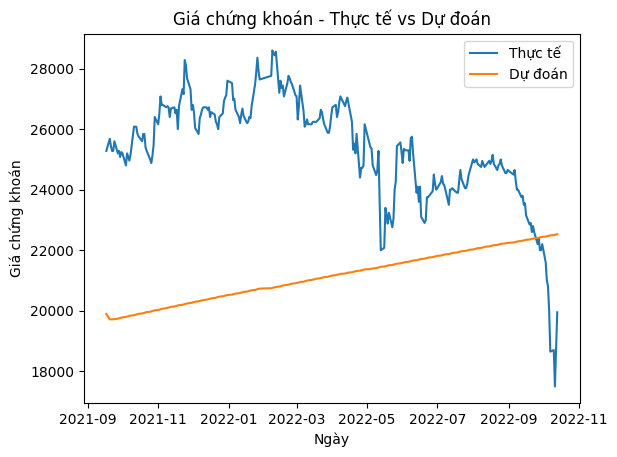

In [11]:
import matplotlib.pyplot as plt

# Vẽ đồ thị cho dữ liệu thực tế và dự đoán trên tập test
plt.plot(test_data.index, test_data['Price'], label='Thực tế')
plt.plot(test_data.index, test_pred[:, 0], label='Dự đoán')
plt.title('Giá chứng khoán - Thực tế vs Dự đoán')
plt.xlabel('Ngày')
plt.ylabel('Giá chứng khoán')
plt.legend()
plt.show()

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Tính toán RMSE, MAPE, MAE trên tập test
test_rmse = np.sqrt(mean_squared_error(test_y, test_pred[:, 0]))
test_mape = np.mean(np.abs((test_y - test_pred[:, 0]) / test_y)) * 100
test_mae = mean_absolute_error(test_y, test_pred[:, 0])

print(f'Test RMSE={test_rmse:.2f}')
print(f'Test MAPE={test_mape:.2f}%')
print(f'Test MAE={test_mae:.2f}')

Test RMSE=4813.68
Test MAPE=16.88%
Test MAE=4366.60


In [7]:
test_pred_df = pd.DataFrame(test_pred)

In [8]:
test_pred_df

,0,1,2,3,4
0,19893.357037,20086.827014,19513.817016,4.423616e+06,-0.009334
1,19718.124799,20001.553376,19418.436804,8.164218e+06,-0.000484
2,19716.248237,19990.278676,19421.312112,1.008980e+07,0.000022
3,19714.839709,19993.345893,19419.431047,1.120645e+07,0.000497
4,19719.561980,20002.183891,19422.191722,1.181761e+07,0.000737
...,...,...,...,...,...
264,22489.738260,22814.488677,22141.969462,1.389650e+07,0.000904
265,22499.460024,22824.335690,22151.527721,1.390144e+07,0.000904
266,22509.174865,22834.175691,22161.079172,1.390638e+07,0.000904
267,22518.882788,22844.008684,22170.623822,1.391132e+07,0.000904
